# Navigation

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the first project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893).

### 1. Start the Environment

We begin by importing some necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Banana.app"`
- **Windows** (x86): `"path/to/Banana_Windows_x86/Banana.exe"`
- **Windows** (x86_64): `"path/to/Banana_Windows_x86_64/Banana.exe"`
- **Linux** (x86): `"path/to/Banana_Linux/Banana.x86"`
- **Linux** (x86_64): `"path/to/Banana_Linux/Banana.x86_64"`
- **Linux** (x86, headless): `"path/to/Banana_Linux_NoVis/Banana.x86"`
- **Linux** (x86_64, headless): `"path/to/Banana_Linux_NoVis/Banana.x86_64"`

For instance, if you are using a Mac, then you downloaded `Banana.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Banana.app")
```

In [2]:
env = UnityEnvironment(file_name="./Banana_Linux_NoVis/Banana.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


### 3. Define and Train the Models

In [5]:
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
import dqn_agent
import importlib
importlib.reload(dqn_agent)
from dqn_agent import DQNAgent
import time
import random
import sys
from rl_config import RLConfig
import pickle
import torch


In [8]:
def test_banana(config=RLConfig()):
    agent = DQNAgent(state_size, brain.vector_action_space_size, config)
    score = 0                                          # initialize the score
    eps = config.eps_start
    
    beta = config.beta0
    start_time = time.time()
    scores=[]
    times=[]
    allSteps = 0
    for episode in range(config.num_episodes_per_evaluation):
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations[0]
        
        score_this_game = 0.        
        while True:
            action = agent.act(state, eps)
            env_info = env.step(action)[brain_name]
            next_state = env_info.vector_observations[0]
            reward = env_info.rewards[0]
            done = env_info.local_done[0]
            beta = min(config.betaf, config.beta0 +
                       (config.betaf - config.beta0)/config.beta_annealing_timesteps * allSteps)
            agent.step(state, action, reward, next_state, done, beta)
            score_this_game += reward
            state = next_state
            if done:
                break
            eps = max(eps * config.eps_decay, config.eps_min)
            allSteps += 1
        if config.verbose and episode % config.print_interval==0:
            print("Episode {} Score {}".format(episode, score_this_game))
        scores.append(score_this_game)
        times.append(time.time() - start_time)
    torch.save(agent.qnetwork_local.state_dict(), config.modelSaveName)

    return scores, times


In [9]:
def test_bananas(config=RLConfig()):
    print("Testing convergence for: {}".format(config.title))
    evaluationScores = []
    for testnum in range(config.num_evaluations):
        seed=random.randint(0,sys.maxsize)
        evaluationScores.append(test_banana(config=config))
        scores_and_times=evaluationScores[-1]
        print("Completed convergence test {} iteration {} with average score of last 100 {}"
              .format(config.title, testnum+1, np.mean(scores_and_times[0][-99:])))
    return evaluationScores

In [10]:
config=RLConfig()
config.title="Baseline DQN"
config.usePER=False
config.useDoubleDQN=False
config.useDuelingDQN=False
config.modelSaveName = "dqn.pth"
dqn_scores_and_times=test_bananas(config)
# Saving the objects:
with open('dqn.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump(dqn_scores_and_times, f)

Testing convergence for: Baseline DQN
Completed convergence test Baseline DQN iteration 1 with average score of last 100 14.909090909090908
Completed convergence test Baseline DQN iteration 2 with average score of last 100 14.080808080808081
Completed convergence test Baseline DQN iteration 3 with average score of last 100 14.222222222222221


In [13]:
config=RLConfig()
config.title="Double DQN"
config.usePER=False
config.useDoubleDQN=True
config.useDuelingDQN=False
config.modelSaveName = "ddqn.pth"
double_dqn_scores_and_times=test_bananas(config)
double_dqn_scores = [d[0] for d in double_dqn_scores_and_times]
with open('ddqn.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump(double_dqn_scores_and_times, f)

Testing convergence for: Double DQN
Completed convergence test Double DQN iteration 1 with average score of last 100 15.171717171717171
Completed convergence test Double DQN iteration 2 with average score of last 100 11.04040404040404
Completed convergence test Double DQN iteration 3 with average score of last 100 13.242424242424242


In [14]:
config=RLConfig()
config.title="Double DQN + PER"
config.usePER=True
config.useDoubleDQN=True
config.useDuelingDQN=False
config.modelSaveName = "ddqn_per.pth"

double_dqn_per_scores_and_times=test_bananas(config)
double_dqn_per_scores = [d[0] for d in double_dqn_per_scores_and_times]
with open('ddqn_per.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump(double_dqn_per_scores_and_times, f)

Testing convergence for: Double DQN + PER
Completed convergence test Double DQN + PER iteration 1 with average score of last 100 14.353535353535353
Completed convergence test Double DQN + PER iteration 2 with average score of last 100 13.505050505050505
Completed convergence test Double DQN + PER iteration 3 with average score of last 100 12.646464646464647


In [15]:
config=RLConfig()
config.title="Dueling DQN"
config.usePER=False
config.useDoubleDQN=True
config.useDuelingDQN=True
config.modelSaveName = "dueling_dqn.pth"

dueling_dqn_scores_and_times=test_bananas(config)
dueling_dqn_scores = [d[0] for d in dueling_dqn_scores_and_times]
with open('dueling_dqn.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump(dueling_dqn_scores_and_times, f)

Testing convergence for: Dueling DQN
Completed convergence test Dueling DQN iteration 1 with average score of last 100 15.95959595959596
Completed convergence test Dueling DQN iteration 2 with average score of last 100 16.404040404040405
Completed convergence test Dueling DQN iteration 3 with average score of last 100 16.050505050505052


In [16]:
config=RLConfig()
config.title="Dueling DQN + PER"
config.usePER=True
config.useDoubleDQN=True
config.useDuelingDQN=True
config.modelSaveName = "dueling_dqn_per.pth"

dueling_dqn_per_scores_and_times=test_bananas(config)
dueling_dqn_per_scores = [d[0] for d in dueling_dqn_per_scores_and_times]
with open('dueling_dqn_per.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump(dueling_dqn_per_scores_and_times, f)

Testing convergence for: Dueling DQN + PER
Completed convergence test Dueling DQN + PER iteration 1 with average score of last 100 14.606060606060606
Completed convergence test Dueling DQN + PER iteration 2 with average score of last 100 15.95959595959596
Completed convergence test Dueling DQN + PER iteration 3 with average score of last 100 15.0


### Analyze Results
The execution produced three convergence runs for each model with five models. In order to more easily compare the models against each other, 

In [11]:
import matplotlib.pyplot as plt
import numpy as np

In [13]:
def get_running_means(data, interval):
    return [np.mean(data[max(i-interval+1,0):i+1]) for i in range(len(data)-1)]

In [14]:
def get_average_score_at_episode(data):
    return [np.mean([data[j][i] for j in range(len(data))]) for i in range(len(data[0]))]

In [15]:
def get_smoothed100_score(data):
    return get_running_means(get_average_score_at_episode(data), 100)

In [16]:
def get_scores(data):
    return [d[0] for d in data]

In [17]:
import pickle
def load_perf_data():
    dqn_data_and_time=pickle.load(open('dqn.pkl','rb'))
    ddqn_data_and_time=pickle.load(open('ddqn.pkl','rb'))
    ddqn_per_data_and_time=pickle.load(open('ddqn_per.pkl','rb'))
    dueling_dqn_data_and_time=pickle.load(open('dueling_dqn.pkl','rb'))
    dueling_dqn_per_data_and_time=pickle.load(open('dueling_dqn_per.pkl','rb'))
    return (get_scores(dqn_data_and_time), 
            get_scores(ddqn_data_and_time), 
            get_scores(ddqn_per_data_and_time), 
            get_scores(dueling_dqn_data_and_time),
           get_scores(dueling_dqn_per_data_and_time))
    

In [18]:
dqn_scores, ddqn_scores, ddqn_per_scores, dueling_dqn_scores, dueling_dqn_per_scores = load_perf_data()

In [19]:
thirteens=[13 for i in range(500)]

### Raw Game Scores and Last 100 Games Moving Average
Here we display the raw scores  along with the smoothed mean where the averaging interval is over the last 100 games. This is done for each of the five models: the baseline DQN, Double DQN, Double DQN with Prioritized Experience Replay, Dueling DQN, and Dueling DQN with Prioritized Experience Replay. Within these limited samples, it seems that the Dueling DQN architecture provides a clear advantage over the Double DQN architecture. 

Text(0.82, 0.9, 'Smoothed100s')

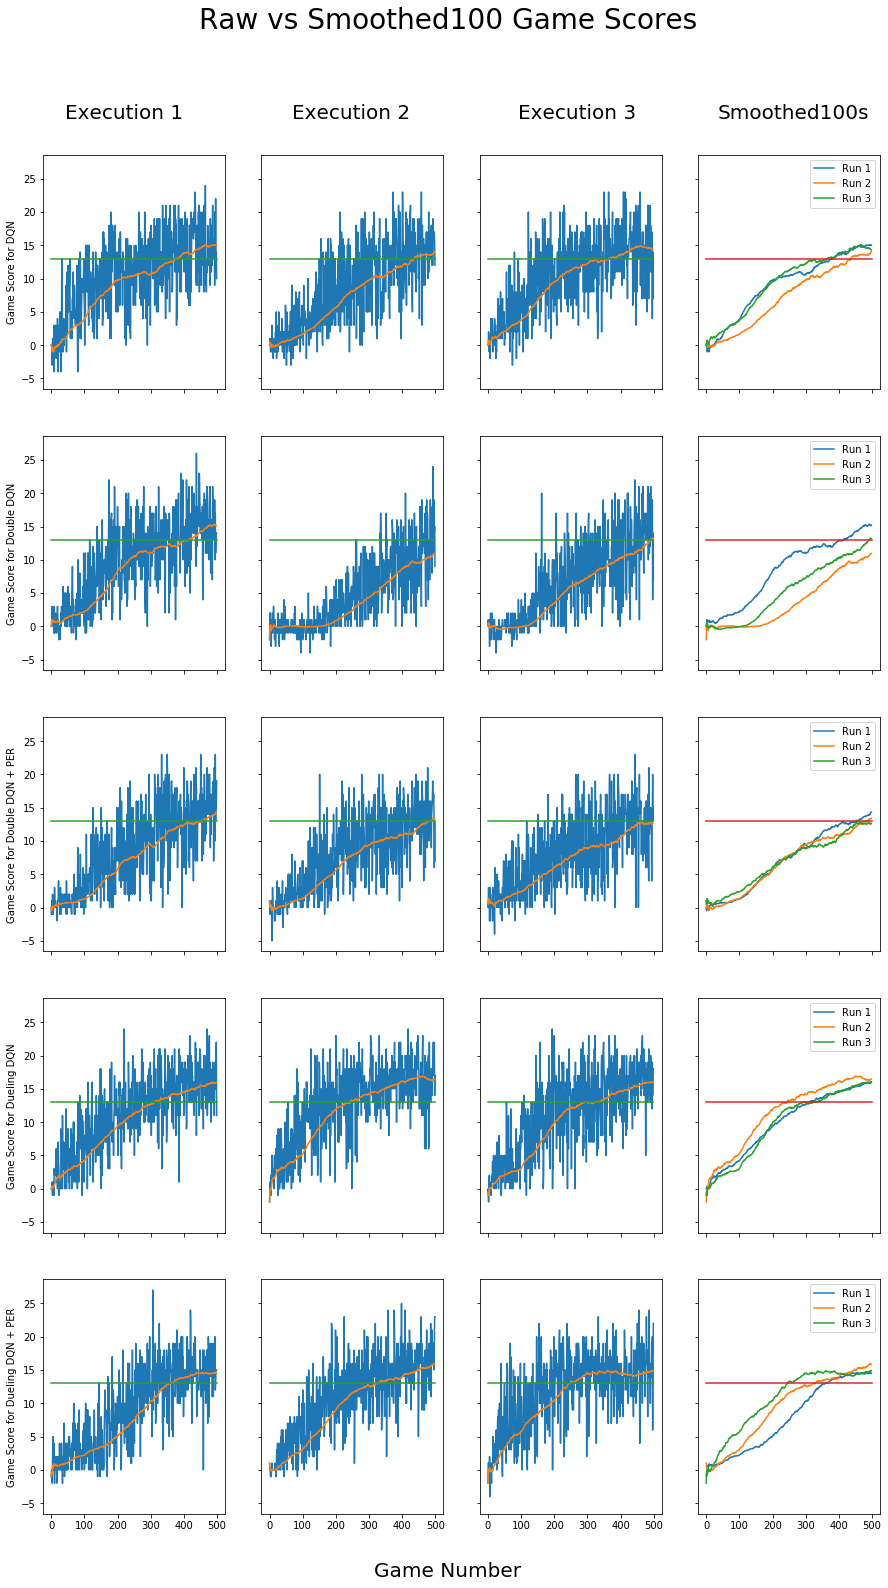

In [20]:
all_scores = [dqn_scores, ddqn_scores, ddqn_per_scores, dueling_dqn_scores, dueling_dqn_per_scores]
labels = ["DQN", "Double DQN", "Double DQN + PER", "Dueling DQN", "Dueling DQN + PER"]
fig,ax = plt.subplots(nrows=5,ncols=4,sharex=True,sharey=True,figsize=(15,25))
for i in range(5):
    ax[i][0].set_ylabel("Game Score for " + labels[i])
    for j in range(3):
        ax[i][j].plot(all_scores[i][j])
        ax[i][j].plot(get_running_means(all_scores[i][j], 100))
        ax[i][j].plot(thirteens)
    for j in range(3):
        ax[i][3].plot(get_running_means(all_scores[i][j], 100), label="Run " + str(j+1))
    ax[i][3].plot(thirteens)
    ax[i][3].legend()
fig.text(0.5, 0.95, 'Raw vs Smoothed100 Game Scores', ha='center', fontsize=28)
fig.text(0.5, 0.09, 'Game Number', ha='center', fontsize=20)
fig.text(0.20,0.9, 'Execution 1', ha='center', fontsize=20)
fig.text(0.41,0.9, 'Execution 2', ha='center', fontsize=20)
fig.text(0.62,0.9, 'Execution 3', ha='center', fontsize=20)
fig.text(0.82, 0.9, 'Smoothed100s', ha='center', fontsize=20)

### Comparing Models
In order to try to limit the potential impact of a single lucky or unlucky run, each of the three runs on each architecture is averaged by taking the mean score at for each episode. This combined training sample for a given model can then be easily compared with the other considered models.

In [21]:
dqn_means=get_smoothed100_score(dqn_scores)
ddqn_means=get_smoothed100_score(ddqn_scores)
ddqn_per_means=get_smoothed100_score(ddqn_per_scores)
dueling_dqn_means=get_smoothed100_score(dueling_dqn_scores)
dueling_dqn_per_means=get_smoothed100_score(dueling_dqn_per_scores)

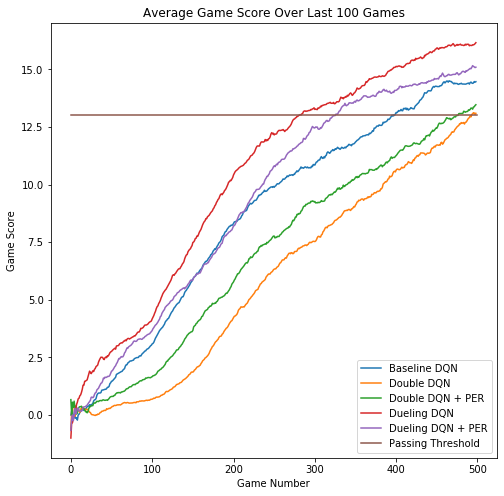

In [22]:
plt.rcParams['figure.figsize'] = [8,8]
plt.plot(dqn_means, label="Baseline DQN")
plt.plot(ddqn_means, label="Double DQN")
plt.plot(ddqn_per_means, label="Double DQN + PER")
plt.plot(dueling_dqn_means, label="Dueling DQN")
plt.plot(dueling_dqn_per_means, label="Dueling DQN + PER")
plt.plot(thirteens, label="Passing Threshold")
plt.ylabel("Game Score")
plt.xlabel("Game Number")
plt.title("Average Game Score Over Last 100 Games")
plt.legend()
plt.show()

In [27]:
def get_episode_meeting_requirement(title, means, requirement):
    vals = [(i, means[i]) for i in range(len(means)) if means[i] >= requirement]
    if len(vals) > 0:
        print("Method {} meets requirement of {} at episode {} with mean {}".format(title, requirement, vals[0][0], vals[0][1] ))
    else:
        print("Method {} failed to meet the requirement of {}".format(title, requirement))

In [28]:
get_episode_meeting_requirement("DQN", dqn_means, 13.0)
get_episode_meeting_requirement("Double DQN", ddqn_means, 13.0)
get_episode_meeting_requirement("Double DQN + PER", ddqn_per_means, 13.0)
get_episode_meeting_requirement("Dueling DQN", dueling_dqn_means, 13.0)
get_episode_meeting_requirement("Dueling DQN + PER", dueling_dqn_per_means, 13.0)

Method DQN meets requirement of 13.0 at episode 395 with mean 13.020000000000003
Method Double DQN meets requirement of 13.0 at episode 493 with mean 13.046666666666665
Method Double DQN + PER meets requirement of 13.0 at episode 474 with mean 13.0
Method Dueling DQN meets requirement of 13.0 at episode 280 with mean 13.0
Method Dueling DQN + PER meets requirement of 13.0 at episode 326 with mean 13.059999999999997


### Evaluation of Model
Here we pick the Dueling DQN + PER model and just run some games using the previously trained model. 

In [6]:
config=RLConfig()
config.title="Dueling DQN + PER"
config.usePER=True
config.useDoubleDQN=True
config.useDuelingDQN=True
config.modelSaveName = "dueling_dqn_per.pth"
agent = DQNAgent(state_size, brain.vector_action_space_size,config)
agent.qnetwork_local.load_state_dict(torch.load("dueling_dqn_per.pth"))
numGames = 10


total_score = 0
for i in range(numGames):
    env_info = env.reset(train_mode=False)[brain_name] # reset the environment
    state = env_info.vector_observations[0]            # get the current state
    game_score = 0
    while True:
        # get the action from the agent per the current state but do not train the agent
        action = agent.act(state)
        env_info = env.step(action)[brain_name]
        next_state = env_info.vector_observations[0]
        reward = env_info.rewards[0]
        done = env_info.local_done[0]
        game_score += reward
        state = next_state
        if done:
            break
    print("Game {} completed with score {}".format(i+1, game_score))
    total_score += game_score
print("Smart Agent completed {} games with Total {} and Average Score {}".format(numGames, total_score, total_score/numGames))
            
env.close()

Game 1 completed with score 15.0
Game 2 completed with score 22.0
Game 3 completed with score 17.0
Game 4 completed with score 23.0
Game 5 completed with score 17.0
Game 6 completed with score 15.0
Game 7 completed with score 14.0
Game 8 completed with score 19.0
Game 9 completed with score 18.0
Game 10 completed with score 16.0
Smart Agent completed 10 games with Total 176.0 and Average Score 17.6


Our pre-trained model seems to score well above the requirement.

## Hyperparameters
The hyperparameters are set by default in rl_config.py

### General Reinforcement Learning Hyperparameters

#### Learning Rate
The learning rate is set to 0.0001. Testing with learning rates of higher values led to poor performance. 

#### Exploration Epsilon
The epsilon begins with a value of 1.0 and decays at a rate of `epsilon*0.9996**total_steps` where total_steps is cumulative across all played games. The minimum value is limited to 0.01 to ensure some residual level of exploration in all games.

#### Parameter Update Rate
The model parameters are updated as `params = tau*new_params + (1.-tau)*params` and tau is set to 0.001 so that the model does not adjust too quickly to new parameters.

#### Future Discount
Gamma reflects a discount given to future rewards versus current rewards. The discount factor is set to 0.999 for a very small discount.

#### Learning Interval
The number of training steps between each learning step. A value of 1 is used so that learning occurs on every training step.

#### Parameter Update Interval
The number of steps between updates to the parameters. The value is set to 4 so that parameter updates occur every fourth training step.

#### Batch Size
The number of samples together in a mini-batch for training the model. A value of 64 is used.

#### Buffer Size
The number of training samples to store in the buffer. A value of 100000 is used.

#### Samples Before Learning
The number of training samples added into the buffer before the model begins learning. The minimum value would be the batch size or 64. A value of 1000 is used.

### Prioritized Experience Replay Hyperparameters
#### Alpha
The priority of each sample is equal to the error in the model prediction. Alpha is an exponent applied to this priority when sampling from the distribution. A value of 1 for alpha would mean that the full error is used as the priority and samplas with high losses would be sampled much more heavily than others. A value of 0 for the exponent forces all values to 1 with the result that samples are chosen uniformly. Here, a value of 0.2 is used providing a small amount of prioritization.

#### Beta
Alpha is applied after the loss is calculated and is stored with the sample. Beta has a similar effect accept that it intends to encompass how we desire more prioritization after many training steps as the error losses are more meaningful then. Beta is linearly annealed from 0.1 to 1.0 over the course of 100k training steps.








## Potential Improvements and Future Work
### Further Evaluation of PER Impacts
In the set of three model convergence runs presented here, adding PER led to a decline in convergence time for both the Double DQN and Dueling DQN cases. It would be desirable to execute far more convergence runs in order to provide a more definitive answer on the effect of PER to this particular problem. Likewise, it would be desirable to test the impact of PER on the learning from pixels case which requires significantly more episodes to converge toward the solution. It should be noted that in this write-up, experience led to decreasing alpha and the starting beta, thereby limiting the impact of PER, as a necessary means towards a converging algorithm.

### Grid Search of Hyperparameters
It would be desirable to perform some level of search over the range for each of the hyperparameters in order to identify optimal values. Some level of experimentation was performed in development with the learning rate, the epsilon decay and minimum, the number of samples before learning, PER-alpha, and PER-beta. However, these were not captured in a systematic fashion.

### Model Search
The neural network architecture used here is a simple feed-forward architecture with two fully connected hidden layers with 128 nodes each. It is not clear whether a simpler model would perform as well or whether adding in additional learning capacity in the form of additional layers or nodes within the layer would lead to overfitting or better performance.